## Requirement 1: Stochatic Environment
**Build a stochastic environment including**
- A distribution over the bids of the other agents
- **A function specifying the probability with which an user buys for every price**

**Pricing algorithm: Build a pricing strategy using the continuous set of prices p ∈ [0, 1] and Gaussian Processes.**\
Bidding algorithm: Consider a sequence of second-price auctions. Build two learning algorithms to deal with the bidding problem:
- primal-dual algorithm for truthful auctions
- UCB-like algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

c:\Users\39327\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\39327\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\39327\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Stochastic Pricing Environment

In [2]:
class StochasticPricingEnvironment:
    def __init__(self, model='linear', alpha=None, beta=None):
        self.model = model
        self.alpha = alpha
        self.beta = beta
        np.random.seed(42)


    # given settled price and number customer
    # returns a sample of number of sale and profit
    def round(self, price_t, n_costumer_t):
        # number of sale at time t
        number_sale_t = np.random.binomial(n_costumer_t, StochasticPricingEnvironment.generate_probability(self.model, self.alpha, self.beta, price_t))

        return number_sale_t

    # TODO
    # integrate inside environment the computation of clairvoyant reward

    # takes as input the selling price -> [0,1]
    # return as output the probability of selling -> [0,1]
    @staticmethod
    def generate_probability(model, a, b, price):
        def isNotNone(s,d):
            if s is None:
                return d
            else:
                return s
        
        if model == 'linear':
            alpha = isNotNone(a, 1) # Intercept
            beta = isNotNone(b, -1)  # Slope
            purchase_probabilities = alpha + beta * price
            
        elif model == 'logit':
            alpha = isNotNone(a, 0)
            beta = isNotNone(b, -5)
            purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta * price)))
            
        elif model == 'probit':
            alpha = isNotNone(a, 0)
            beta = isNotNone(b, -5)
            purchase_probabilities = norm.cdf(alpha + beta * price)
            
        elif model == 'KERNEL':
            purchase_probabilities = np.abs(np.sin(2 * np.pi * price) * np.exp(-price * 5) + price * .10) + .1

        return purchase_probabilities


### Pricing Agent : Gaussian Process Agent with RBF kernel and UCB algorithm

In [3]:
# Radial Basis Function Kernel
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [4]:
# From the agent's point of view, action set is [0,1]. 
# If the actual actions are outside this set, perform rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, product_cost, maximum_price=1, scale=0.1, discretization=None):
        self.T = T
        if(discretization is None):
            # discretization prescribed by theory
            epsilon = T**(-0.33)
            discretization = int(1/epsilon)
        self.product_cost = product_cost
        self.arms = np.linspace(product_cost, maximum_price, discretization)
        self.gp = RBFGaussianProcess(scale=scale).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self, bidding_cost=0):
        # play every arm at least once
        if self.t < len(self.arms):
            self.a_t = self.t
        else:
            self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
            #    averages of GP  +  estimation uncertainty
            buy_probabilities = self.mu_t + self.beta(self.t) * self.sigma_t
            # print(buy_probabilities)
            # print(self.arms - bidding_cost)
            ucbs = buy_probabilities * (self.arms - bidding_cost)
            # print(ucbs)
            self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, n_sales_t, n_customers_t, total_cost_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, (self.arms[self.a_t]-total_cost_t)*n_sales_t)
        estimated_probability = n_sales_t / n_customers_t
        self.gp = self.gp.fit(self.arms[self.a_t], estimated_probability)
        self.t += 1

In [5]:
# UCB1 agent for performance comparison
class UCB1Agent:
    def __init__(self, T, K=None, range=1):
        if K is None:
            # prescribed by theory
            epsilon = T**(-0.33)
            K = int(1/epsilon)
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

### Simulation

In [6]:
def MinMaxScaler(original, min_x, max_x):
    return (original - min_x) / (max_x - min_x)

def MinMaxRescaler(scaled, min_x, max_x):
    return min_x + (max_x - min_x) * scaled

T = 500
n_customers = 100
min_price, max_price = 10, 20
cost = 10
payed_bid_per_user = 0
discretization = 50

np.random.seed(42)
agent = GPUCBAgent(T, MinMaxScaler(cost, min_price, max_price), MinMaxScaler(max_price, min_price, max_price))
ucb_agent = UCB1Agent(T, K=discretization)
env = StochasticPricingEnvironment(model='linear', alpha=0.9, beta=-0.8)

# let's compute the clairvoyant
prices = np.linspace(min_price, max_price, discretization)
conversion_probability = lambda price: 1-MinMaxScaler(price, min_price, max_price)
gross_reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = gross_reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer
profit_curve = gross_reward_function(prices, n_customers*conversion_probability(prices)) - np.repeat(n_customers*payed_bid_per_user, discretization)
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

agent_rewards = []
ucb_agent_rewards = []
for t in range(T):
    # payed_bid_per_user = t % 3

    # UCB1 agent
    pi_t = ucb_agent.pull_arm() ## the agent returns the index of arm (price)!!
    p_t = prices[pi_t] # I get the actual price
    number_sale_t = env.round(MinMaxScaler(p_t, min_price, max_price), n_customers)
    r_t = (p_t - cost)*number_sale_t
    ucb_agent.update(r_t)
    ucb_agent_rewards.append(r_t)

    # GPUCB agent
    p_t = agent.pull_arm(bidding_cost=payed_bid_per_user/(max_price-min_price))
    number_sale_t = env.round(p_t, n_customers)
    total_profit_t = number_sale_t * (MinMaxRescaler(p_t, min_price, max_price) - cost - payed_bid_per_user)
    # print(f'round {t} : p_t={p_t}, number_sale_t={number_sale_t}, total_profit_t={total_profit_t}, bid={payed_bid_per_user}')
    agent.update(number_sale_t, n_customers, MinMaxScaler(cost+payed_bid_per_user, min_price, max_price) )
    agent_rewards.append(total_profit_t - n_customers*payed_bid_per_user)
    # agent.update((total_profit_t - n_customers*payed_bid_per_user)/n_customers)
    

agent_rewards = np.array(agent_rewards)
cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
ucb_agent_rewards = np.array(ucb_agent_rewards)
ucb_cumulative_regret = np.cumsum(expected_clairvoyant_rewards-ucb_agent_rewards)

[0.85618478 0.74529345 0.62635327 0.50127007 0.37209513 0.24096921
 0.11006353]
[3.28967528e-03 1.26322914e-03 3.00430054e-04 2.02293052e-05
 2.66972770e-04 1.12592087e-03 2.91613857e-03]
[0.8752273  0.75260574 0.62809233 0.50138717 0.37364052 0.24748669
 0.1269438 ]


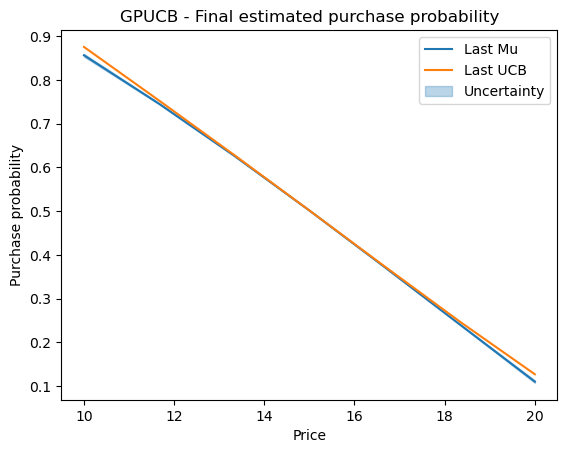

In [7]:
print(agent.mu_t)
print(agent.sigma_t)
print(agent.mu_t + agent.beta(agent.t) * agent.sigma_t)

plt.plot(np.linspace(10,20,len(agent.mu_t)), agent.mu_t, label='Last Mu')
plt.plot(np.linspace(10,20,len(agent.mu_t)), agent.mu_t + agent.beta(agent.t) * agent.sigma_t, label='Last UCB')
plt.fill_between(np.linspace(10,20,len(agent.mu_t)), agent.mu_t-agent.sigma_t, agent.mu_t+agent.sigma_t, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated purchase probability')
plt.xlabel('Price')
plt.ylabel('Purchase probability')
plt.legend()
plt.show();

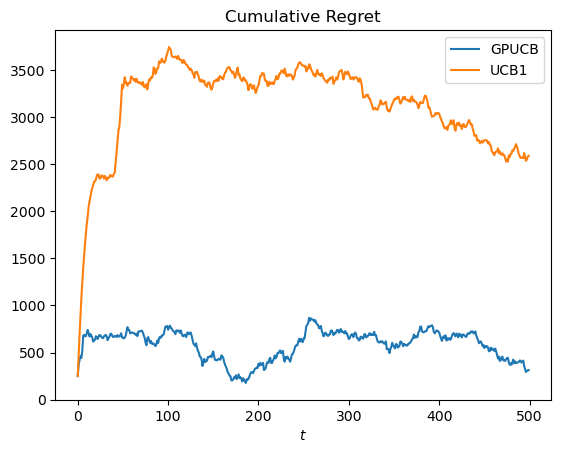

In [17]:
plt.figure()
plt.plot(cumulative_regret, label="GPUCB")
plt.plot(ucb_cumulative_regret, label="UCB1")
plt.legend()
plt.title('Cumulative Regret')
plt.xlabel('$t$')
plt.show();

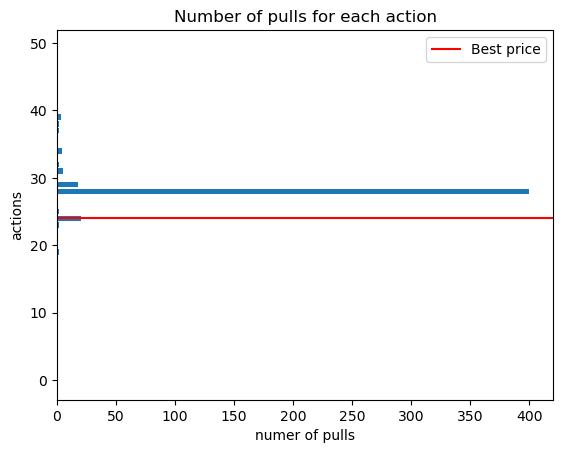

In [18]:
plt.figure()
plt.barh(np.arange(discretization), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

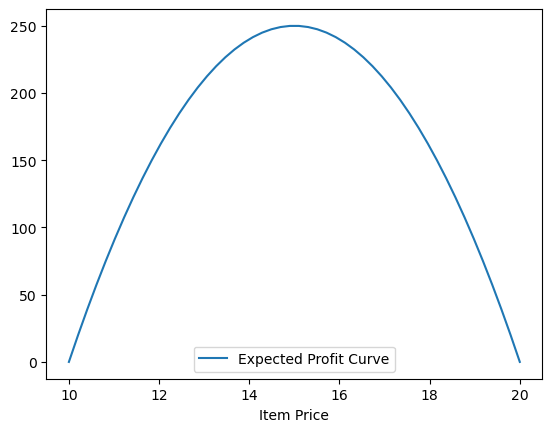

In [56]:
plt.figure()
plt.plot(prices,profit_curve, label='Expected Profit Curve')
plt.xlabel('Item Price')
plt.legend()
plt.show();
